This notebook explores gaussian processes in GPflow by training one on som generated data. 

First off lets import all the default imports

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set(style="darkgrid")
np.random.seed(1)

Now lets generate some data and plot it

In [46]:
X = np.random.rand(200, 1)
Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + np.random.randn(200,1) * 0.01
df = pd.DataFrame(np.hstack((X, Y)), columns=list('XY'))

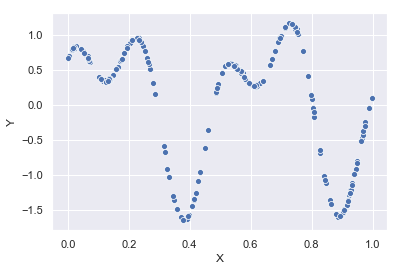

In [47]:
sns.scatterplot(x="X", y="Y", data=df)

With that in place we can now build our GPflow model 

In [48]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

The code below will learn the parameters using ML

In [49]:
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -512.114037
  Number of iterations: 32
  Number of functions evaluations: 38


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -512.114037
  Number of iterations: 32
  Number of functions evaluations: 38


In [ ]:
Lets plot the fit

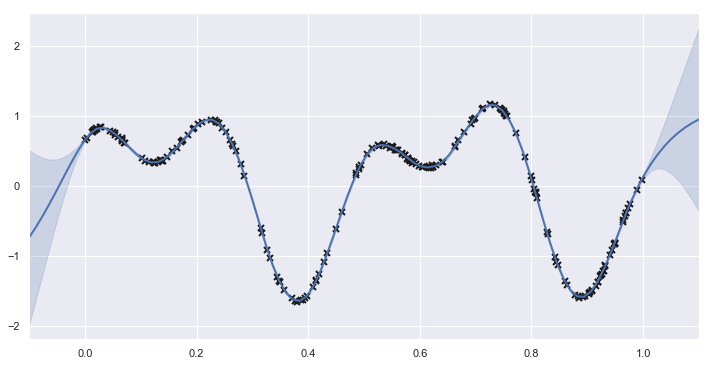

In [50]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)
    
plot(m)

The fit looks pretty neat! Now lets put priors on the hyperparameters  This runs on an nvidia card on my machine and takes a couple seconds.

In [51]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.21741004094070154
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,4.494731104798825
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.0001051296987412428
GPR/mean_function/A,Parameter,"N(0.0,10.0)",(none),True,"(1, 1)",True,[[1.275035218652909]]
GPR/mean_function/b,Parameter,"N(0.0,10.0)",(none),True,(),True,-0.6666629439058851


and use HMC to sample the posterior. The parameters estimated by ML will be the starting position of the sampler.

In [54]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, 
                         num_samples=gpflow.test_util.notebook_niter(500), 
                         epsilon=0.05, 
                         lmin=10, 
                         lmax=20, 
                         logprobs=False)

plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

TypeError: sample() got an unexpected keyword argument 'verbose'

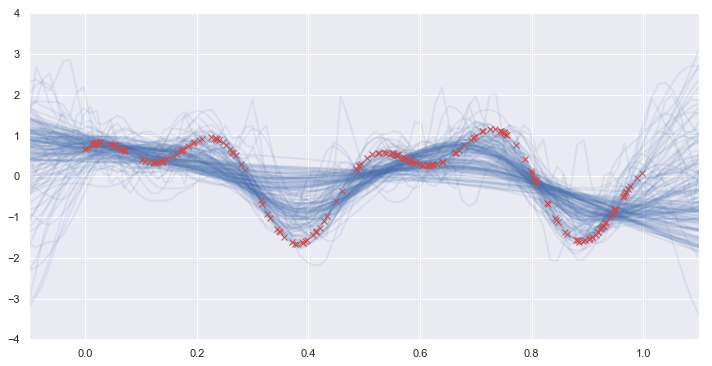

In [53]:
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)

plt.plot(X, Y, 'rx')
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(-4, 4)